# Figure 2: Trajectory nonlinearity

This notebook calculates error distributions for LKM, SM, SG, and MOGP, and visualization of the most nonlinear trajectories

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
from analysis_utils import *

from pathlib import Path
import joblib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp

In [3]:
# Formatting params
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")

col_palette = ['#176D9C', '#DBA137','#86AF49' ,'#df473c','#ae3c60', '#82b4bb', '#176D9C']
parameters = {'axes.labelsize': 35,
                'axes.titlesize': 40,
                'xtick.labelsize': 30,
                'ytick.labelsize': 30,
                'legend.fontsize': 30,
                'font.size': 10,
                'figure.subplot.hspace': 0.2,
                'figure.subplot.wspace': 0.1, 
                'legend.frameon': False}
plt.rcParams.update(parameters)

label_projs = {'aals':'AALS', 'ceft': 'CEFT', 'emory': 'EMORY', 'proact': 'PRO-ACT'}

In [4]:
def rank_err(data_mod, mod_dict):
    """Calculate model error for all models in model dict"""
    # checks that order of patients is identical for both models, and that correct data dictionary is passed
    np.testing.assert_array_equal(mod_dict['linear'].Y, mod_dict['rbf'].Y, err_msg='lin and rbf models not trained on same data')
    np.testing.assert_array_equal(mod_dict['linear'].X, mod_dict['rbf'].X, err_msg='lin and rbf models not trained on same data')
    np.testing.assert_array_equal(mod_dict['rbf'].X, data_mod['XA'], err_msg='mogp models and data dictionary not trained on same data') 

    err_dict = {}
    for key in mod_dict.keys():
            err_dict[key] = calc_rmse_full_mod(data=data_mod, model_type=key, mod=mod_dict[key])

    return err_dict

def calc_rmse_full_mod(data, model_type=None, mod=None):
    """Calculate RMSE for model"""
    num_patients = len(data['SI'])
    err_arr = np.zeros((num_patients, 1))
    for i in range(0,num_patients):
        y_real, y_pred_mean = calc_y_pred_full_data(data=data, i=i, model_type=model_type, mod=mod)
        err_arr[i] = calc_error(y_real, y_pred_mean)
        
    return err_arr

def calc_y_pred_full_data(data, i, model_type=None, mod=None):
    """Pass in all X and Y model data"""
    x_real = data['XA'][i]
    x_real = x_real[~np.isnan(x_real)]
    y_real = data['YA'][i]
    y_real = y_real[~np.isnan(y_real)]
    
    y_pred = calc_y_pred(model_type=model_type, x_train=x_real,y_train=y_real, x_pred=x_real, mod=mod, i=i)
    assert y_real.shape == y_pred.shape, 'prediction and original y vectors not same shape'
        
    return y_real, y_pred
    
def calc_perc_nonlin_thresh(mod_err_comp, mod_err_rbf, err_thresh=0.1):
    """Calculate difference in error (rmse) between comparison model (comp model - rbf model)"""
    err_diff = mod_err_comp - mod_err_rbf
    perc_above = (sum(err_diff > err_thresh)/len(err_diff))[0]
    perc_mid = (sum((-err_thresh < err_diff) & (err_diff < err_thresh))/len(err_diff))[0]
    perc_below = (sum(-err_diff > err_thresh)/len(err_diff))[0]
    
    return err_diff, perc_above, perc_mid, perc_below

In [5]:
def gen_err_nonlin(map_dict, projects, data_path, experiment_name):
    """Generate dataframe of RMSE error between original data and model mean functions"""
    df_err = pd.DataFrame(columns=['project', 'kernel', 'err'])
    for proj in projects:
        mod_dict = map_dict[proj]
        proj_data = joblib.load(data_path / 'data_{}_{}.pkl'.format(proj, experiment_name))
        
        err_dict = rank_err(proj_data, mod_dict) 
        for key in err_dict.keys():
            df_key = pd.DataFrame(err_dict[key], columns=['err'])
            df_key['kernel']=key
            df_key['project']=proj
            df_err = df_err.append(df_key)
    
    return df_err

In [6]:
def gen_clust_summ_agg(proj, map_dict, proj_data, comp='slope'):
    """Rank clusters in order of linearity (MoGP vs comp1 Model)"""
    err_dict = rank_err(proj_data, map_dict)
    assert (comp in err_dict.keys()), 'missing comp in errdict: {}'.format(comp)
    err_diff = err_dict[comp]-err_dict['rbf']
    df_clust_sum = pd.DataFrame(zip(map_dict['rbf'].z, err_diff[:,0], proj_data['SI']), columns=['rbf_clust_num', 'err_diff', 'SI'])
    df_cluster_aggregate = df_clust_sum.groupby('rbf_clust_num')[['err_diff']].mean().join(df_clust_sum['rbf_clust_num'].value_counts())
    df_cluster_aggregate.sort_values('err_diff', ascending=False, inplace=True)
    
    return df_cluster_aggregate

In [7]:
def format_perc_table(df_perc_diff):
    "Format table showing percent differences between models at varying RMSE thresholds"
    df_perc = df_perc_diff.pivot(index='project', columns='thresh').round(2)['perc_above']
    df_perc.rename(index=label_projs, inplace=True)
    df_perc = df_perc.applymap(lambda x : '{:.2f}%'.format(x))
    return df_perc

# Supp. Table 1: Percentage of ALS participants in each dataset, for which a MoGP outperforms a LKM by a RMSE threshold

In [8]:
proj_lis = ['aals', 'ceft', 'emory', 'proact']
model_type_lis = ['rbf', 'linear', 'slope',  'sigmoid']
comp_lis = [x for x in model_type_lis if x != 'rbf']

In [9]:
# Load models for all baseline models
exp_path = Path('data/model_data/1_alsfrsr_all')
exp_name = 'min3_alsfrst'
proj_map_dict = {}
for cur_proj in proj_lis:
    tmp_mod_dict = {}
    for cur_mod_type in model_type_lis:
        if (cur_mod_type is 'rbf') or (cur_mod_type is 'linear'):
            cur_model_suffix = 'model_{}_{}'.format(cur_proj, exp_name)
            tmp_mod_dict[cur_mod_type]=get_map_model(exp_path / 'results' / cur_mod_type, cur_model_suffix)
        elif (cur_mod_type is 'slope') or (cur_mod_type is 'sigmoid'):
            tmp_mod_dict[cur_mod_type]=None
#         elif cur_mod_type is 'lme':
#             tmp_proj_data = joblib.load(exp_path / 'data_{}_{}.pkl'.format(cur_proj, exp_name))
#             tmp_mod_dict[cur_mod_type] = train_lme_model(tmp_proj_data)
    proj_map_dict[cur_proj]=tmp_mod_dict

seed did not pass monotonicity test: 1
seed did not pass monotonicity test: 2
best seed: 3, ll -1278.4487999097823
best seed: 0, ll -1580.6520295803944
best seed: 2, ll -1223.028158410827
best seed: 1, ll -2460.0283026681464
seed did not pass monotonicity test: 2
best seed: 3, ll -1248.0646004570403
best seed: 1, ll -1692.2141976791986
seed did not pass monotonicity test: 3
seed did not pass monotonicity test: 4
best seed: 2, ll -3853.8510614331317
best seed: 2, ll -10632.485282565887


In [10]:
thresh_lis = [0, 1, 2, 3, 4, 5]
df_perc_comp = pd.DataFrame(columns=['project', 'comp', 'thresh', 'perc_above', 'perc_mid', 'perc_below'])

for cur_proj in proj_lis:
    cur_dict = proj_map_dict[cur_proj]
    cur_proj_data = joblib.load(exp_path / 'data_{}_{}.pkl'.format(cur_proj, exp_name))
    cur_err_dict = rank_err(cur_proj_data, cur_dict)
    
    for cur_thresh in thresh_lis:
        for curcomp in comp_lis: #compare all baselines against rbf model
            _, cur_perc_above, cur_perc_mid, cur_perc_below = calc_perc_nonlin_thresh(mod_err_comp=cur_err_dict[curcomp], mod_err_rbf=cur_err_dict['rbf'], err_thresh=cur_thresh)
            df_perc_comp = df_perc_comp.append({'project': cur_proj, 'comp':'{}-{}'.format(curcomp, 'rbf'), 'thresh': cur_thresh, 'perc_above': cur_perc_above*100,  'perc_mid': cur_perc_mid*100, 'perc_below': cur_perc_below*100}, ignore_index=True)

In [11]:
for disp_comp in df_perc_comp['comp'].unique():
    print('Comparison: {}'.format(disp_comp))
    df_disp = format_perc_table(df_perc_comp[df_perc_comp['comp']==disp_comp])
    df_disp
    df_disp.to_csv('reports/supp_table_rmse_mod_thresh_{}_rbf.csv'.format(disp_comp))

Comparison: linear-rbf


thresh,0,1,2,3,4,5
project,,,,,,
AALS,71.27%,27.19%,8.33%,2.85%,0.88%,0.22%
CEFT,75.42%,39.29%,16.18%,6.51%,3.78%,1.26%
EMORY,74.44%,31.08%,11.78%,5.01%,2.01%,1.50%
PRO-ACT,77.87%,27.16%,9.99%,3.73%,1.27%,0.31%


Comparison: slope-rbf


thresh,0,1,2,3,4,5
project,,,,,,
AALS,37.28%,11.40%,3.29%,1.32%,0.44%,0.00%
CEFT,59.24%,24.37%,6.30%,2.73%,2.10%,0.42%
EMORY,45.61%,11.03%,4.76%,2.51%,1.50%,0.75%
PRO-ACT,61.27%,19.43%,5.71%,1.95%,0.58%,0.17%


Comparison: sigmoid-rbf


thresh,0,1,2,3,4,5
project,,,,,,
AALS,41.01%,9.43%,3.51%,0.66%,0.22%,0.00%
CEFT,32.14%,4.20%,0.21%,0.00%,0.00%,0.00%
EMORY,35.59%,9.02%,3.01%,1.25%,0.75%,0.50%
PRO-ACT,45.54%,4.21%,0.27%,0.00%,0.00%,0.00%


# Figure 2A : Distribution (CDF) for 3 comparison models

In [12]:
df_err_nonlin = gen_err_nonlin(proj_map_dict, proj_lis, exp_path, exp_name)

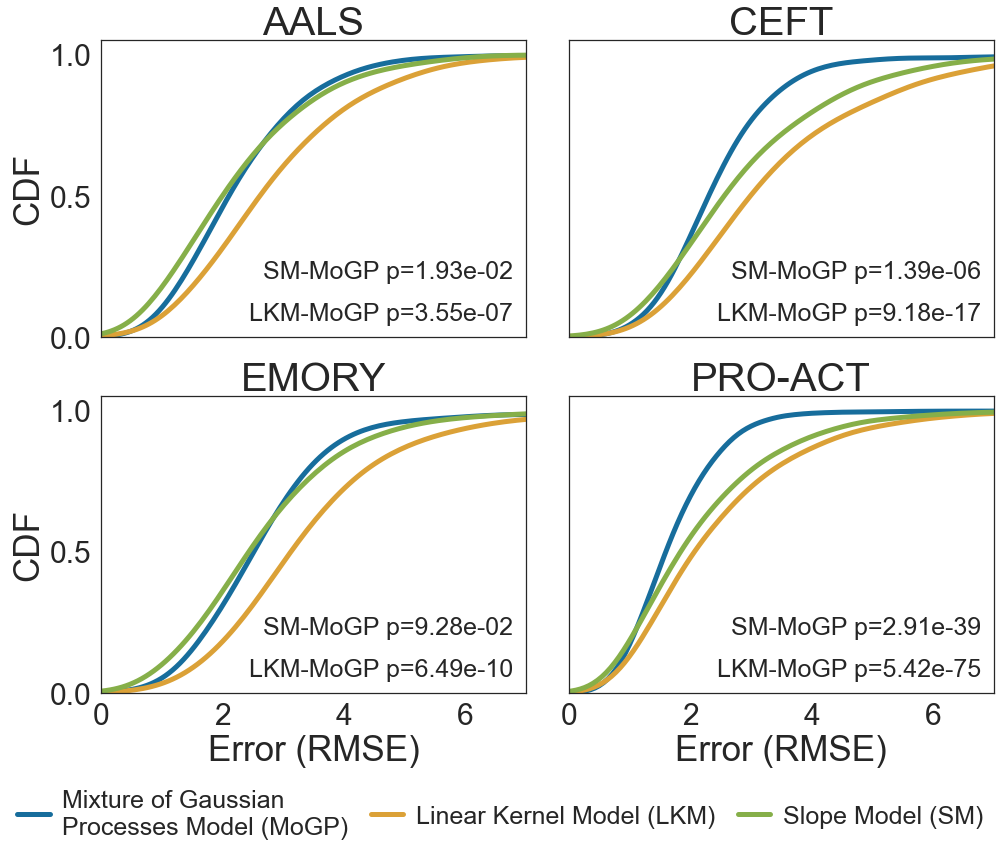

In [13]:
mod_labels = {'rbf_err': 'Mixture of Gaussian \nProcesses Model (MoGP)', 'lin_err':'Linear Kernel Model (LKM)', 'slope_err':'Slope Model (SM)'}

fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharey=True, sharex=True)
for j, cur_proj in enumerate(proj_lis):
    cur_df_rbf = df_err_nonlin[(df_err_nonlin['project']==cur_proj)&(df_err_nonlin['kernel']=='rbf')]
    cur_df_lin = df_err_nonlin[(df_err_nonlin['project']==cur_proj)&(df_err_nonlin['kernel']=='linear')]
    cur_df_slope = df_err_nonlin[(df_err_nonlin['project']==cur_proj)&(df_err_nonlin['kernel']=='slope')]

    [ks_stat_rbf_lin, ks_p_val_rbf_lin] = ks_2samp(cur_df_rbf['err'], cur_df_lin['err'])
    [ks_stat_rbf_slope, ks_p_val_rbf_slope] = ks_2samp(cur_df_rbf['err'], cur_df_slope['err'])
    
    _ = sns.kdeplot(cur_df_rbf['err'], ax=axs.flat[j], label=mod_labels['rbf_err'], cumulative=True, linewidth=5, color=col_palette[0])
    _ = sns.kdeplot(cur_df_lin['err'], ax=axs.flat[j], label=mod_labels['lin_err'], cumulative=True, linewidth=5, color=col_palette[1])
    _ = sns.kdeplot(cur_df_slope['err'], ax=axs.flat[j], label=mod_labels['slope_err'], cumulative=True, linewidth=5, color=col_palette[2])

    _ = axs.flat[j].set_title(label_projs[cur_proj])
    _ = axs.flat[j].set_ylabel('CDF')
    _ = axs.flat[j].set_xlabel('Error (RMSE)')

    _ = axs.flat[j].text(0.97, 0.04 ,'LKM-MoGP p={:.2e}'.format(float(ks_p_val_rbf_lin)), transform=axs.flat[j].transAxes, va='bottom', ha='right', fontsize=25)
    _ = axs.flat[j].text(0.97, 0.18,'SM-MoGP p={:.2e}'.format(float(ks_p_val_rbf_slope)), transform=axs.flat[j].transAxes, va='bottom', ha='right', fontsize=25)

    _ = axs.flat[j].set_xlim([0, 7])

_ = axs.flat[2].tick_params(labelbottom=True)
_ = axs.flat[2].legend(bbox_to_anchor=(-0.25, -0.25), loc='upper left', ncol=3, fontsize=25, columnspacing=0.9, handlelength=1.3, handletextpad=0.5)


# Save figure
fig.savefig('reports/fig_cdfs.pdf', bbox_inches='tight')


# Figure 2B: Visualization of most nonlinear trajectories in PROACT

In [14]:
cur_proj = 'proact'
cur_proj_data = joblib.load(exp_path / 'data_{}_{}.pkl'.format(cur_proj, exp_name))
cur_model = proj_map_dict[cur_proj]['rbf']
df_clust_sum_agg = gen_clust_summ_agg('proact', proj_map_dict[cur_proj], cur_proj_data, comp='slope')

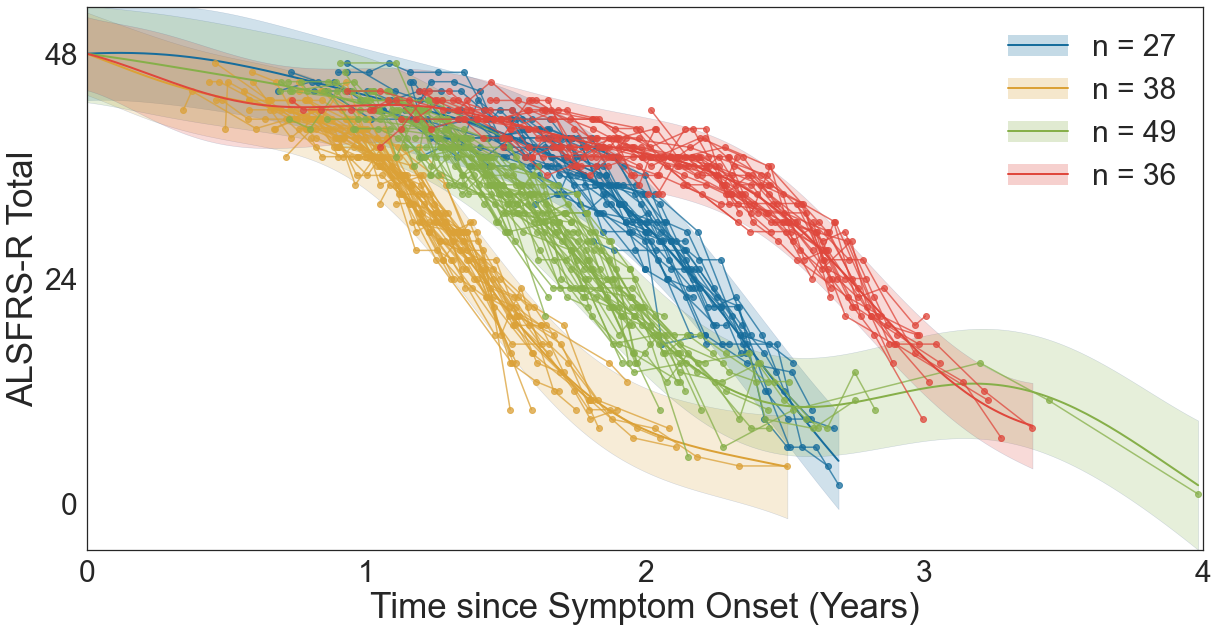

In [15]:
disp_clust = 4
min_clust_size = 25
vis_clust = df_clust_sum_agg[df_clust_sum_agg['rbf_clust_num']>min_clust_size].index[:disp_clust]

fig, ax = plt.subplots(1,1, figsize = (20, 10))

for j, clust in enumerate(vis_clust):
    ax, k_num_pat = plot_mogp_by_clust(ax, cur_model, cur_proj_data, clust, data_flag=True, 
                       data_col=col_palette[j], model_flag=True, model_col=col_palette[j], gpy_pad=0)
ax = format_mogp_axs(ax, max_x=4, x_step=1.0, )

# Edit legend
handles, labels = ax.get_legend_handles_labels()
handles = [(x, matplotlib.patches.Patch(color=x.get_color(), alpha=0.25, linewidth=0)) for x in handles]
_ = ax.legend(handles=handles, labels=labels, frameon=False)
    
# for line in ax.get_legend().get_lines():
#     line.set_linewidth(7)
    
_ = ax.set_ylabel('ALSFRS-R Total')
_ = ax.set_xlabel('Time since Symptom Onset (Years)')

# Save Figure
fig.savefig('reports/fig_nonlin_trajectories_byslope.pdf', bbox_inches='tight')


# Supp Table: Number of clusters in linear, rbf, slope models

In [16]:
# Generate table
df_num_clusters = pd.DataFrame(columns=['proj', 'rbf', 'linear', 'slope'])
for cur_proj in proj_map_dict.keys():
    rbf_num = len(np.where(proj_map_dict[cur_proj]['rbf'].allocmodel.Nk>0)[0])
    lin_num = len(np.where(proj_map_dict[cur_proj]['linear'].allocmodel.Nk>0)[0])
    num_pats = proj_map_dict[cur_proj]['rbf'].allocmodel.N
    df_num_clusters = df_num_clusters.append({'proj': cur_proj, 'rbf': rbf_num, 'linear': lin_num, 'slope': num_pats}, ignore_index=True)
    
# Format table
df_num_clusters.columns = ['Study', 'Number of clusters in RBF Kernel', 'Number of clusters in Linear kernel', 'Number of slope models']
df_num_clusters['Study'] = df_num_clusters['Study'].replace(label_projs)
df_num_clusters

df_num_clusters.to_csv('reports/supp_table_total_num_clust_proj.csv', index=False)

,Study,Number of clusters in RBF Kernel,Number of clusters in Linear kernel,Number of slope models
0,AALS,22,25,456
1,CEFT,34,44,476
2,EMORY,25,30,399
3,PRO-ACT,92,127,2923
